I think after a rough period, we finally might have the complete results to understand the importance of having a consistent metric across embedding and clustering methods and also the importance of the choice of metric itself.

We have results for embeddings generated from Node2Vec with Dot similarity (default), Cosine similarity and Euclidan Distance, that are clustered using K-Means++ which uses Euclidean (default), dot similarity and cosine similarity.

We have 10,000 node LFR networks of increasing network density and mixing used to generate the embeddings and clustering. We also wish to change the dimension of the embeddings to see the differences there, but for today, we rest easy with this.

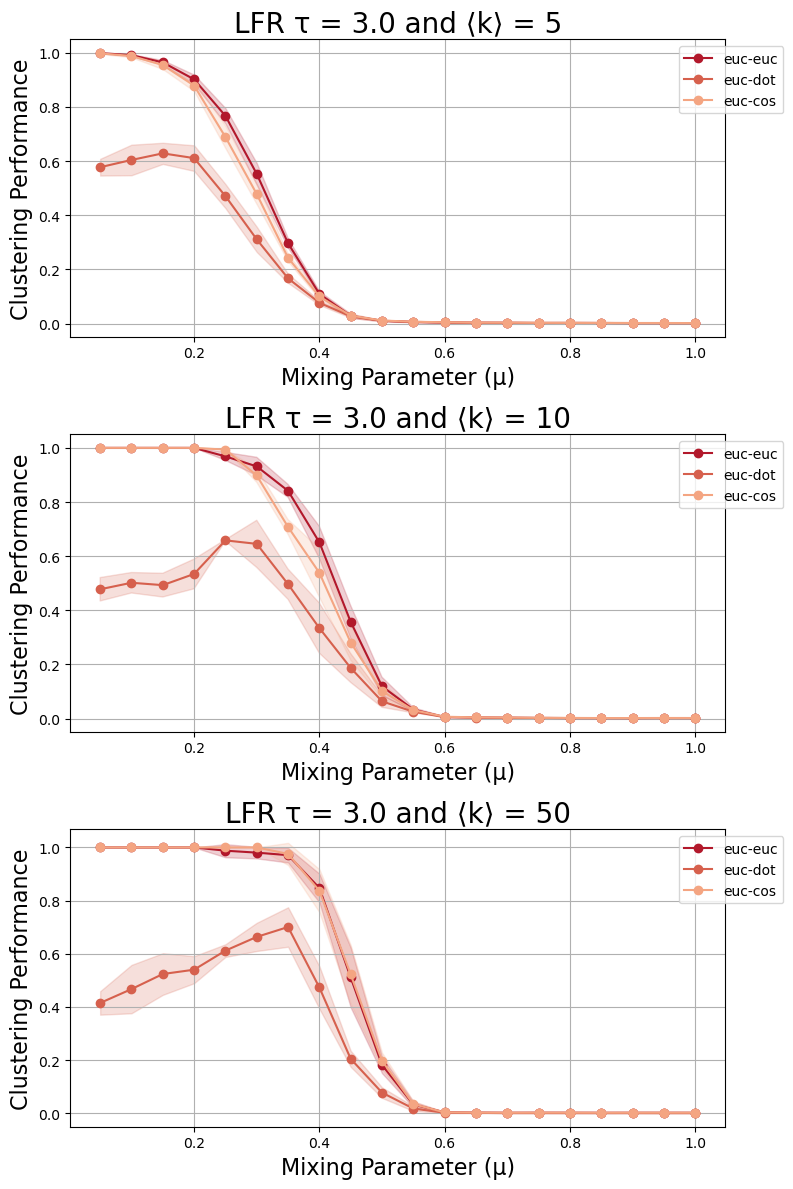

In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

# --- Font sizes for styling ---
font_sizes = {
    "title": 20,
    "axis_title": 16,
    "axis_label": 14,
    "legend": 10,
    "suptitle": 18,
}

# --- Settings ---
dims = [5, 10, 50]  # Network dimensions (or average degree values)
embedding_types = ['euclidean', 'cosine', 'dot']
score_keys = ['kmeans++', 'kmeans_euclidean', 'kmeans_dot', 'kmeans_cosine']

# Map score keys to short labels (for curve labels)
score_label_map = {
    'kmeans++': '++',
    'kmeans_euclidean': 'euc',
    'kmeans_dot': 'dot',
    'kmeans_cosine': 'cos'
}

# Short names for embedding types (for curve labels)
embed_short = {'euclidean': 'euc', 'cosine': 'cos', 'dot': 'dot'}

color_scheme = {
    'euclidean': {  # Red spectrum
        '++': '#67001F',   # Dark maroon
        'euc': '#B2182B',   # Strong red
        'dot': '#D6604D',   # Medium red
        'cos': '#F4A582'    # Light red
    },
    'cosine': {  # Blue spectrum
        '++': '#08306B',   # Dark blue
        'euc': '#08519C',   # Strong blue
        'dot': '#2171B5',   # Medium blue
        'cos': '#4292C6'    # Light blue
    },
    'dot': {  # Green spectrum
        '++': '#00441B',   # Dark green
        'euc': '#006D2C',   # Strong green
        'dot': '#238B45',   # Medium green
        'cos': '#41AB5D'    # Light green
    }
}


# ------------------------------


#curves_to_show = []  # Leave empty to show all curves
# curves_to_show = [f"{embed_short[embed]}-{score_label_map[sk]}" 
#                               for embed in ['euclidean', 'cosine', 'dot'] 
#                                 for sk in ['kmeans++', 'kmeans_euclidean', 'kmeans_dot', 'kmeans_cosine']]

curves_to_show = [f"{embed_short[embed]}-{score_label_map[sk]}" 
                              for embed in ['euclidean', 'cosine', 'dot'] 
                                for sk in ['kmeans_euclidean', 'kmeans_dot', 'kmeans_cosine']]
                                  
# ------------------------------

data = {}
for dim in dims:
    data[dim] = {}
    for embed in embedding_types:
        file_path = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_n2v_metric_change_10000_{dim}_3.0_minc50/n2v_{embed}_kmeans_clustering.txt"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, delimiter=',')
            # Group by 'mu' and compute mean and std for each score key.
            grouped = df.groupby('mu')[score_keys].agg(['mean','std']).reset_index()
            # Flatten the MultiIndex columns.
            grouped.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in grouped.columns.values]
            data[dim][embed] = grouped
        else:
            print(f"File not found: {file_path}. Skipping embedding '{embed}' for dimension {dim}.")

# --- Create Matplotlib Subplots ---
# Arrange subplots vertically (one per dimension). Adjust figure size as needed.
fig, axes = plt.subplots(nrows=len(dims), ncols=1, figsize=(8, 4*len(dims)))

# If there is only one subplot, ensure axes is iterable.
if len(dims) == 1:
    axes = [axes]

for ax, dim in zip(axes, dims):
    # Loop through each embedding type and each clustering metric.
    for embed in embedding_types:
        if embed not in data[dim]:
            continue
        df = data[dim][embed]
        for sk in score_keys:
            mean_col = f"{sk}_mean"
            std_col = f"{sk}_std"
            if mean_col not in df.columns or std_col not in df.columns:
                continue
            # Construct curve label: e.g., "dot-cos" for embedding 'dot' and clustering metric 'kmeans_cosine'
            label = f"{embed_short[embed]}-{score_label_map[sk]}"
            # Determine if this curve should be plotted.
            if curves_to_show and (label not in curves_to_show):
                continue
            base_color = color_scheme[embed][score_label_map[sk]]
            # Plot the mean curve.
            ax.plot(df['mu'], df[mean_col], '-o', label=label, color=base_color)
            # Plot the error band.
            ax.fill_between(df['mu'], df[mean_col] - df[std_col], df[mean_col] + df[std_col],
                            color=base_color, alpha=0.2)
    ax.set_xlabel("Mixing Parameter (μ)", fontsize=font_sizes["axis_title"])
    ax.set_ylabel("Clustering Performance", fontsize=font_sizes["axis_title"])
    ax.set_title(f"LFR τ = 3.0 and ⟨k⟩ = {dim}", fontsize=font_sizes["title"])
    ax.grid(True)
    ax.legend(fontsize=font_sizes["legend"], bbox_to_anchor=(1.1, 1))

plt.tight_layout()
plt.show()


In [5]:
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# --- Settings and Styling ---
dims = [5, 10, 50]  # Network dimensions (or average degree values)
embedding_types = ['euclidean', 'cosine', 'dot']
score_keys = ['kmeans++', 'kmeans_euclidean', 'kmeans_dot', 'kmeans_cosine']

score_label_map = {
    'kmeans++': '++',
    'kmeans_euclidean': 'euc',
    'kmeans_dot': 'dot',
    'kmeans_cosine': 'cos'
}

embed_short = {'euclidean': 'euc', 'cosine': 'cos', 'dot': 'dot'}

color_scheme = {
    'euclidean': {
        '++': '#67001F',
        'euc': '#B2182B',
        'dot': '#D6604D',
        'cos': '#F4A582'
    },
    'cosine': {
        '++': '#08306B',
        'euc': '#08519C',
        'dot': '#2171B5',
        'cos': '#4292C6'
    },
    'dot': {
        '++': '#00441B',
        'euc': '#006D2C',
        'dot': '#238B45',
        'cos': '#41AB5D'
    }
}

# Build list of all curve labels (e.g., "euc-++", "euc-euc", etc.)
all_curves = [f"{embed_short[embed]}-{score_label_map[sk]}"
              for embed in embedding_types
              for sk in score_keys]

# ------------------------------
# Load and process data.
data = {}
for dim in dims:
    data[dim] = {}
    for embed in embedding_types:
        file_path = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_n2v_metric_change_10000_{dim}_3.0_minc50/n2v_{embed}_kmeans_clustering.txt"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, delimiter=',')
            # Group by 'mu' and compute mean and std for each score key.
            grouped = df.groupby('mu')[score_keys].agg(['mean', 'std']).reset_index()
            # Flatten the MultiIndex columns.
            grouped.columns = ['_'.join(col).strip() if col[1] != '' else col[0]
                                for col in grouped.columns.values]
            data[dim][embed] = grouped
        else:
            print(f"File not found: {file_path}. Skipping embedding '{embed}' for dimension {dim}.")

# ------------------------------
# Build the Plotly figure.
rows = len(dims)
fig = make_subplots(
    rows=rows, cols=1,
    subplot_titles=[f"LFR τ = 3.0 and ⟨k⟩ = {dim}" for dim in dims],
    vertical_spacing=0.1
)

# Add traces for every embedding and clustering metric.
for i, dim in enumerate(dims, start=1):
    for embed in embedding_types:
        if embed not in data[dim]:
            continue
        df = data[dim][embed]
        for sk in score_keys:
            mean_col = f"{sk}_mean"
            std_col = f"{sk}_std"
            if mean_col not in df.columns or std_col not in df.columns:
                continue
            label = f"{embed_short[embed]}-{score_label_map[sk]}"
            base_color = color_scheme[embed][score_label_map[sk]]
            # Add the main trace, only showing legend for the first subplot.
            fig.add_trace(go.Scatter(
                x=df['mu'],
                y=df[mean_col],
                mode='lines+markers',
                name=label,
                line=dict(color=base_color),
                showlegend=(i == 1)
            ), row=i, col=1)
            # Add the error band trace.
            upper = df[mean_col] + df[std_col]
            lower = df[mean_col] - df[std_col]
            
            fig.add_trace(go.Scatter(
                x=list(df['mu']) + list(df['mu'][::-1]),
                y=list(upper) + list(lower[::-1]),
                fill='toself',
                fillcolor=base_color,
                opacity=0.2,
                line=dict(color='rgba(255,255,255,0)'),
                hoverinfo="skip",
                name=label,             # Assign the same name as the main trace.
                showlegend=False,
                legendgroup=label
            ), row=i, col=1)

    fig.update_xaxes(title_text="Mixing Parameter (μ)", row=i, col=1)
    fig.update_yaxes(title_text="Clustering Performance", row=i, col=1)

fig.update_layout(
    height=400*rows,
    margin=dict(l=50, r=50, t=50, b=50)
)

# Export the Plotly figure as HTML (without full HTML wrapper)
plotly_div = pio.to_html(fig, full_html=False, include_plotlyjs=True)

# ------------------------------
# Build the full HTML file with checkboxes.
html_string = f"""
<html>
  <head>
    <meta charset="utf-8">
    <title>Interactive Clustering Performance Plot</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
  </head>
  <body>
    <div style="width: 80%; margin: auto;">
      <h1 style="text-align:center;">Interactive Clustering Performance Plot</h1>
      <div id="controls">
        <h3>Select Curves:</h3>
        {"".join(f'<label style="margin-right:15px;"><input type="checkbox" class="curve-checkbox" value="{curve}" checked> {curve}</label>' for curve in all_curves)}
      </div>
      <div id="plot">
        {plotly_div}
      </div>
    </div>
    <script>
      // When the page loads, get a reference to the Plotly graph div.
      var graphDiv = document.getElementsByClassName('plotly-graph-div')[0];
      
      // Function to update trace visibility based on checkboxes.
      function updateTraces() {{
        var checkboxes = document.getElementsByClassName('curve-checkbox');
        var newVisibility = [];
        // Loop over all traces in the Plotly figure.
        for (var i = 0; i < graphDiv.data.length; i++) {{
          var traceName = graphDiv.data[i].name;
          var visible = false;
          for (var j = 0; j < checkboxes.length; j++) {{
            if (checkboxes[j].value === traceName && checkboxes[j].checked) {{
              visible = true;
              break;
            }}
          }}
          // Set trace visibility: true means visible; 'legendonly' hides trace but keeps legend.
          newVisibility.push(visible ? true : 'legendonly');
        }}
        Plotly.update(graphDiv, {{visible: newVisibility}});
      }}
      
      // Attach event listeners to checkboxes.
      var checkboxes = document.getElementsByClassName('curve-checkbox');
      for (var i = 0; i < checkboxes.length; i++) {{
        checkboxes[i].addEventListener('change', updateTraces);
      }}
    </script>
  </body>
</html>
"""

# Write the HTML string to a file.
with open("interactive_plot.html", "w") as f:
    f.write(html_string)

print("interactive_plot.html has been created. Open it in your browser to interact with the plot.")


interactive_plot.html has been created. Open it in your browser to interact with the plot.


In [3]:
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# --- Settings and Styling ---
dims = [5, 10, 50]  # Network dimensions (or average degree values)
embedding_types = ['euclidean', 'cosine', 'dot']
score_keys = ['kmeans++', 'kmeans_euclidean', 'kmeans_dot', 'kmeans_cosine']

score_label_map = {
    'kmeans++': '++',
    'kmeans_euclidean': 'euc',
    'kmeans_dot': 'dot',
    'kmeans_cosine': 'cos'
}

embed_short = {'euclidean': 'euc', 'cosine': 'cos', 'dot': 'dot'}

color_scheme = {
    'euclidean': {
        '++': '#67001F',
        'euc': '#B2182B',
        'dot': '#D6604D',
        'cos': '#F4A582'
    },
    'cosine': {
        '++': '#08306B',
        'euc': '#08519C',
        'dot': '#2171B5',
        'cos': '#4292C6'
    },
    'dot': {
        '++': '#00441B',
        'euc': '#006D2C',
        'dot': '#238B45',
        'cos': '#41AB5D'
    }
}

# Build list of all curve labels.
# First add the original curves.
all_curves = []
for embed in embedding_types:
    for sk in score_keys:
        all_curves.append(f"{embed_short[embed]}-{score_label_map[sk]}")
    # Then add altmeans curves.
    for alt in ['altmeans_euclidean', 'altmeans_dot', 'altmeans_cosine']:
        # Use the altmeans label map.
        alt_label_map = {
            'altmeans_euclidean': 'alt-euc',
            'altmeans_dot': 'alt-dot',
            'altmeans_cosine': 'alt-cos'
        }
        all_curves.append(f"{embed_short[embed]}-{alt_label_map[alt]}")

# Remove duplicates while preserving order.
seen = set()
all_curves_unique = []
for curve in all_curves:
    if curve not in seen:
        seen.add(curve)
        all_curves_unique.append(curve)
all_curves = all_curves_unique

# ------------------------------
# Load and process data for kmeans files.
data = {}
for dim in dims:
    data[dim] = {}
    for embed in embedding_types:
        file_path = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_n2v_metric_change_10000_{dim}_3.0_minc50/n2v_{embed}_kmeans_clustering.txt"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, delimiter=',')
            # Group by 'mu' and compute mean and std for each score key.
            grouped = df.groupby('mu')[score_keys].agg(['mean', 'std']).reset_index()
            # Flatten the MultiIndex columns.
            grouped.columns = ['_'.join(col).strip() if col[1] != '' else col[0]
                                for col in grouped.columns.values]
            data[dim][embed] = grouped
        else:
            print(f"File not found: {file_path}. Skipping embedding '{embed}' for dimension {dim}.")

# ------------------------------
# Load and process altmeans data.
# (Assuming altmeans data exists for each dim with the same minc50 folder.)
alt_data = {}
for dim in dims:
    alt_data[dim] = {}
    for embed in embedding_types:
        file_path_alt = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_n2v_metric_change_10000_{dim}_3.0_minc50/n2v_{embed}_altmeans_clustering.txt"
        if os.path.exists(file_path_alt):
            df_alt = pd.read_csv(file_path_alt, delimiter=',')
            # Rename columns: change "proposed_*" to "altmeans_*"
            df_alt.rename(columns={
                'proposed_euclidean': 'altmeans_euclidean',
                'proposed_cosine': 'altmeans_cosine',
                'proposed_dot': 'altmeans_dot'
            }, inplace=True)
            # Define new altmeans score keys.
            alt_score_keys = ['altmeans_euclidean', 'altmeans_dot', 'altmeans_cosine']
            grouped_alt = df_alt.groupby('mu')[alt_score_keys].agg(['mean', 'std']).reset_index()
            grouped_alt.columns = ['_'.join(col).strip() if col[1] != '' else col[0]
                                    for col in grouped_alt.columns.values]
            alt_data[dim][embed] = grouped_alt
        else:
            print(f"File not found: {file_path_alt}. Skipping altmeans for embedding '{embed}' for dimension {dim}.")

# Define a new label map for altmeans curves.
alt_score_label_map = {
    'altmeans_euclidean': 'alt-euc',
    'altmeans_dot': 'alt-dot',
    'altmeans_cosine': 'alt-cos'
}
# For choosing colors for altmeans, we map the altmeans key to the same key used in color_scheme.
alt_key_to_color = {
    'altmeans_euclidean': 'euc',
    'altmeans_dot': 'dot',
    'altmeans_cosine': 'cos'
}

# ------------------------------
# Build the Plotly figure.
rows = len(dims)
fig = make_subplots(
    rows=rows, cols=1,
    subplot_titles=[f"LFR τ = 3.0 and ⟨k⟩ = {dim}" for dim in dims],
    vertical_spacing=0.1
)

# This set will help us add one legend item per unique curve label.
legend_added = set()

# Add traces for every embedding and clustering metric (kmeans curves).
for i, dim in enumerate(dims, start=1):
    for embed in embedding_types:
        if embed not in data[dim]:
            continue
        df = data[dim][embed]
        for sk in score_keys:
            mean_col = f"{sk}_mean"
            std_col = f"{sk}_std"
            if mean_col not in df.columns or std_col not in df.columns:
                continue
            label = f"{embed_short[embed]}-{score_label_map[sk]}"
            base_color = color_scheme[embed][score_label_map[sk]]
            show_leg = True if label not in legend_added else False
            legend_added.add(label)
            # Add the main trace.
            fig.add_trace(go.Scatter(
                x=df['mu'],
                y=df[mean_col],
                mode='lines+markers',
                name=label,
                line=dict(color=base_color),
                showlegend=show_leg,
                legendgroup=label
            ), row=i, col=1)
            # Add the error band trace (note: same name as main trace).
            upper = df[mean_col] + df[std_col]
            lower = df[mean_col] - df[std_col]
            fig.add_trace(go.Scatter(
                x=list(df['mu']) + list(df['mu'][::-1]),
                y=list(upper) + list(lower[::-1]),
                fill='toself',
                fillcolor=base_color,
                opacity=0.2,
                line=dict(color='rgba(255,255,255,0)'),
                hoverinfo="skip",
                name=label,  # same name as main trace
                showlegend=False,
                legendgroup=label
            ), row=i, col=1)
    # Add altmeans curves for each dim.
    for embed in embedding_types:
        if embed not in alt_data[dim]:
            continue
        df_alt = alt_data[dim][embed]
        for ask in alt_score_label_map.keys():
            mean_col = f"{ask}_mean"
            std_col = f"{ask}_std"
            if mean_col not in df_alt.columns or std_col not in df_alt.columns:
                continue
            label = f"{embed_short[embed]}-{alt_score_label_map[ask]}"
            base_color = color_scheme[embed][alt_key_to_color[ask]]
            show_leg = True if label not in legend_added else False
            legend_added.add(label)
            # Add the altmeans main trace.
            fig.add_trace(go.Scatter(
                x=df_alt['mu'],
                y=df_alt[mean_col],
                mode='lines+markers',
                name=label,
                line=dict(color=base_color, dash='dash'),
                showlegend=show_leg,
                legendgroup=label
            ), row=i, col=1)
            # Add the altmeans error band trace (note: same name as main trace).
            upper = df_alt[mean_col] + df_alt[std_col]
            lower = df_alt[mean_col] - df_alt[std_col]
            fig.add_trace(go.Scatter(
                x=list(df_alt['mu']) + list(df_alt['mu'][::-1]),
                y=list(upper) + list(lower[::-1]),
                fill='toself',
                fillcolor=base_color,
                opacity=0.2,
                line=dict(color='rgba(255,255,255,0)'),
                hoverinfo="skip",
                name=label,  # same name as main trace
                showlegend=False,
                legendgroup=label
            ), row=i, col=1)
    fig.update_xaxes(title_text="Mixing Parameter (μ)", row=i, col=1)
    fig.update_yaxes(title_text="Clustering Performance", row=i, col=1)

fig.update_layout(
    height=400 * rows,
    margin=dict(l=50, r=50, t=50, b=50)
)

# Export the Plotly figure as HTML (without full HTML wrapper)
plotly_div = pio.to_html(fig, full_html=False, include_plotlyjs=True)

# ------------------------------
# Build the full HTML file with checkboxes.
html_string = f"""
<html>
  <head>
    <meta charset="utf-8">
    <title>Interactive Clustering Performance Plot</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
  </head>
  <body>
    <div style="width: 80%; margin: auto;">
      <h1 style="text-align:center;">Interactive Clustering Performance Plot</h1>
      <div id="controls">
        <h3>Select Curves:</h3>
        {"".join(f'<label style="margin-right:15px;"><input type="checkbox" class="curve-checkbox" value="{curve}" checked> {curve}</label>' for curve in all_curves)}
      </div>
      <div id="plot">
        {plotly_div}
      </div>
    </div>
    <script>
      // When the page loads, get a reference to the Plotly graph div.
      var graphDiv = document.getElementsByClassName('plotly-graph-div')[0];
      
      // Function to update trace visibility based on checkboxes.
      function updateTraces() {{
        var checkboxes = document.getElementsByClassName('curve-checkbox');
        var newVisibility = [];
        // Loop over all traces in the Plotly figure.
        for (var i = 0; i < graphDiv.data.length; i++) {{
          var traceName = graphDiv.data[i].name;
          var visible = false;
          for (var j = 0; j < checkboxes.length; j++) {{
            if (checkboxes[j].value === traceName && checkboxes[j].checked) {{
              visible = true;
              break;
            }}
          }}
          // Set trace visibility: true means visible; 'legendonly' hides trace but keeps legend.
          newVisibility.push(visible ? true : 'legendonly');
        }}
        Plotly.update(graphDiv, {{visible: newVisibility}});
      }}
      
      // Attach event listeners to checkboxes.
      var checkboxes = document.getElementsByClassName('curve-checkbox');
      for (var i = 0; i < checkboxes.length; i++) {{
        checkboxes[i].addEventListener('change', updateTraces);
      }}
    </script>
  </body>
</html>
"""

# Write the HTML string to a file.
with open("interactive_plot.html", "w") as f:
    f.write(html_string)

print("interactive_plot.html has been created. Open it in your browser to interact with the plot.")


interactive_plot.html has been created. Open it in your browser to interact with the plot.


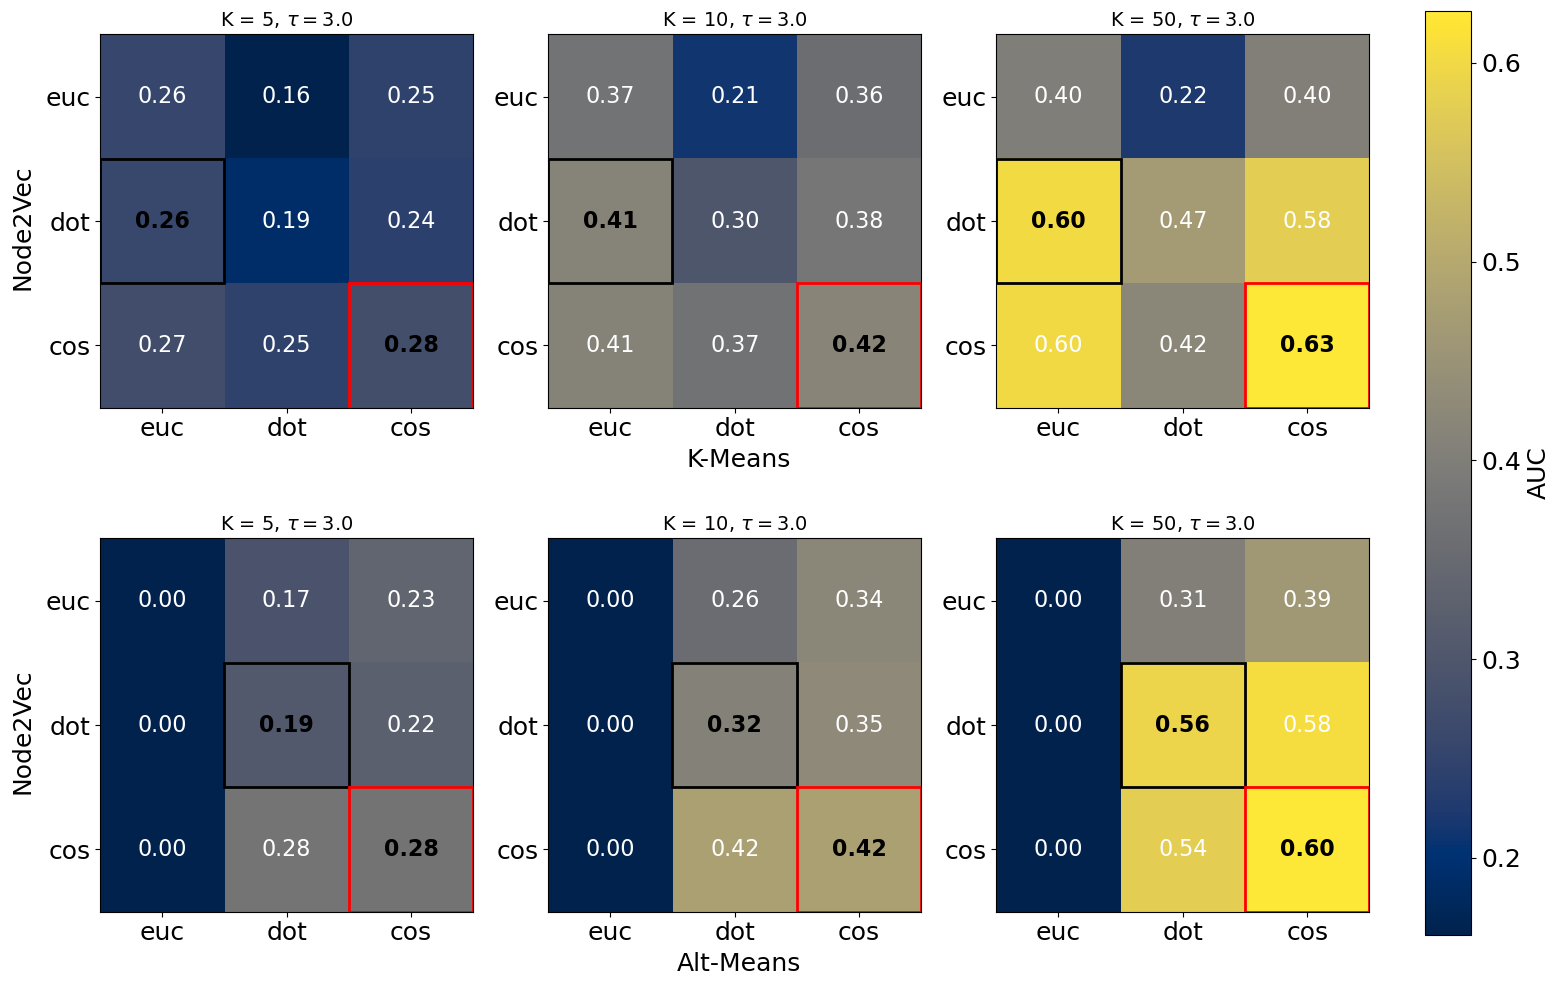

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# SETTINGS & STYLING
dims = [5, 10, 50]  # Network dimensions
embedding_types = ['euclidean', 'cosine', 'dot']
score_keys = ['kmeans++', 'kmeans_euclidean', 'kmeans_dot', 'kmeans_cosine']
score_label_map = {
    'kmeans++': '++',
    'kmeans_euclidean': 'euc',
    'kmeans_dot': 'dot',
    'kmeans_cosine': 'cos'
}
embed_short = {'euclidean': 'euc', 'cosine': 'cos', 'dot': 'dot'}

# For altmeans curves, display labels are the same.
alt_score_label_map = {
    'altmeans_euclidean': 'euc',
    'altmeans_dot': 'dot',
    'altmeans_cosine': 'cos'
}

# Text size options
text_size = 16      # annotation text size
title_size = 14     # subplot title size
axis_label_size = 18  # overall axis label size
tick_label_size = 18  # tick label size

# ------------------------------
# Load and process data for kmeans files.
data = {}
for dim in dims:
    data[dim] = {}
    for embed in embedding_types:
        file_path = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_n2v_metric_change_10000_{dim}_3.0_minc50/n2v_{embed}_kmeans_clustering.txt"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, delimiter=',')
            # Group by 'mu' and compute mean and std for each score key.
            grouped = df.groupby('mu')[score_keys].agg(['mean', 'std']).reset_index()
            # Flatten the MultiIndex columns.
            grouped.columns = ['_'.join(col).strip() if col[1] != '' else col[0]
                                for col in grouped.columns.values]
            data[dim][embed] = grouped
        else:
            print(f"File not found: {file_path}. Skipping embedding '{embed}' for dimension {dim}.")

# ------------------------------
# Load and process altmeans data.
alt_data = {}
for dim in dims:
    alt_data[dim] = {}
    for embed in embedding_types:
        file_path_alt = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_n2v_metric_change_10000_{dim}_3.0_minc50/n2v_{embed}_altmeans_clustering.txt"
        if os.path.exists(file_path_alt):
            df_alt = pd.read_csv(file_path_alt, delimiter=',')
            # Rename columns: change "proposed_*" to "altmeans_*"
            df_alt.rename(columns={
                'proposed_euclidean': 'altmeans_euclidean',
                'proposed_cosine': 'altmeans_cosine',
                'proposed_dot': 'altmeans_dot'
            }, inplace=True)
            # Define new altmeans score keys.
            alt_score_keys = ['altmeans_euclidean', 'altmeans_dot', 'altmeans_cosine']
            grouped_alt = df_alt.groupby('mu')[alt_score_keys].agg(['mean', 'std']).reset_index()
            grouped_alt.columns = ['_'.join(col).strip() if col[1] != '' else col[0]
                                    for col in grouped_alt.columns.values]
            alt_data[dim][embed] = grouped_alt
        else:
            print(f"File not found: {file_path_alt}. Skipping altmeans for embedding '{embed}' for dimension {dim}.")

# --- Compute AUC for kmeans curves ---
auc_kmeans = []
for dim in dims:
    for embed in embedding_types:
        if embed not in data[dim]:
            continue
        df = data[dim][embed]
        for sk in score_keys:
            mean_col = f"{sk}_mean"
            if mean_col not in df.columns:
                continue
            # Compute area under the curve: integrate the mean over the mixing parameter (mu)
            auc = np.trapz(df[mean_col], df['mu'])
            # Determine consistency: for each embedding type, only one score key is "consistent"
            if (embed == 'euclidean' and sk == 'kmeans_euclidean') or \
               (embed == 'cosine' and sk == 'kmeans_cosine') or \
               (embed == 'dot' and sk == 'kmeans_dot'):
                consistency = 'consistent'
            else:
                consistency = 'inconsistent'
            auc_kmeans.append({
                'dim': dim,
                'embed': embed,
                'score_key': sk,
                'auc': auc,
                'consistency': consistency,
                'curve_label': f"{embed_short[embed]}-{score_label_map[sk]}"
            })
df_kmeans = pd.DataFrame(auc_kmeans)

# --- Compute AUC for altmeans curves ---
auc_alt = []
for dim in dims:
    for embed in embedding_types:
        if embed not in alt_data[dim]:
            continue
        df_alt = alt_data[dim][embed]
        for ask in alt_score_label_map.keys():
            mean_col = f"{ask}_mean"
            if mean_col not in df_alt.columns:
                continue
            auc = np.trapz(df_alt[mean_col], df_alt['mu'])
            if (embed == 'euclidean' and ask == 'altmeans_euclidean') or \
               (embed == 'cosine' and ask == 'altmeans_cosine') or \
               (embed == 'dot' and ask == 'altmeans_dot'):
                consistency = 'consistent'
            else:
                consistency = 'inconsistent'
            auc_alt.append({
                'dim': dim,
                'embed': embed,
                'alt_score_key': ask,
                'auc': auc,
                'consistency': consistency,
                'curve_label': f"{embed_short[embed]}-{alt_score_label_map[ask]}"
            })
df_alt = pd.DataFrame(auc_alt)

# ------------------------------
# Define ordering.
row_order = ['euclidean', 'dot', 'cosine']    # actual data order
row_labels = ['euc', 'dot', 'cos']              # displayed labels
col_order_means = ['kmeans_euclidean', 'kmeans_dot', 'kmeans_cosine']
col_order_alt = ['altmeans_euclidean', 'altmeans_dot', 'altmeans_cosine']
col_labels = ['euc', 'dot', 'cos']

# Compute global min and max for color scaling.
global_min_means = df_kmeans['auc'].min()
global_max_means = df_kmeans['auc'].max()
global_min_alt = df_alt['auc'].min()
global_max_alt = df_alt['auc'].max()

# Create subplots: two rows and three columns.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# Loop over each dimension to plot heatmaps.
for j, dim in enumerate(dims):
    # --- Top row: K-Means heatmap for dimension dim ---
    df_k_dim = df_kmeans[df_kmeans['dim'] == dim]
    pivot_means = df_k_dim.pivot(index='embed', columns='score_key', values='auc')
    pivot_means = pivot_means.reindex(index=row_order, columns=col_order_means)
    
    ax = axes[0, j]
    im = ax.imshow(pivot_means, vmin=global_min_means, vmax=global_max_means, cmap='cividis')
    # Subplot title: cluster size and tau.
    ax.set_title(f"K = {dim}, $\\tau = 3.0$", fontsize=title_size)
    
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_xticklabels(col_labels, fontsize=tick_label_size)
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_yticklabels(row_labels, fontsize=tick_label_size)
    
    # Annotate cells.
    for i in range(len(row_order)):
        for k in range(len(col_order_means)):
            value = pivot_means.iloc[i, k]
            if pd.notna(value):
                if (i == 1 and k == 0) or (i == 2 and k == 2):
                    ax.text(k, i, f"{value:.2f}", ha="center", va="center",
                            color="black", fontsize=text_size, fontweight="bold")
                else:
                    ax.text(k, i, f"{value:.2f}", ha="center", va="center",
                            color="w", fontsize=text_size)
    
    # Add borders.
    default_rect = plt.Rectangle((0 - 0.5, 1 - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(default_rect)
    cos_cos_rect = plt.Rectangle((2 - 0.5, 2 - 0.5), 1, 1, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(cos_cos_rect)
    
    # --- Bottom row: Alt-Means heatmap for dimension dim ---
    df_a_dim = df_alt[df_alt['dim'] == dim]
    pivot_alt = df_a_dim.pivot(index='embed', columns='alt_score_key', values='auc')
    pivot_alt = pivot_alt.reindex(index=row_order, columns=col_order_alt)
    
    ax2 = axes[1, j]
    im2 = ax2.imshow(pivot_alt, vmin=global_min_alt, vmax=global_max_alt, cmap='cividis')
    ax2.set_title(f"K = {dim}, $\\tau = 3.0$", fontsize=title_size)
    
    ax2.set_xticks(np.arange(len(col_labels)))
    ax2.set_xticklabels(col_labels, fontsize=tick_label_size)
    ax2.set_yticks(np.arange(len(row_labels)))
    ax2.set_yticklabels(row_labels, fontsize=tick_label_size)
    
    # Annotate cells.
    for i in range(len(row_order)):
        for k in range(len(col_order_alt)):
            value = pivot_alt.iloc[i, k]
            if pd.notna(value):
                if (i == 1 and k == 1) or (i == 2 and k == 2):
                    ax2.text(k, i, f"{value:.2f}", ha="center", va="center",
                             color="black", fontsize=text_size, fontweight="bold")
                else:
                    ax2.text(k, i, f"{value:.2f}", ha="center", va="center",
                             color="w", fontsize=text_size)
    
    default_rect = plt.Rectangle((1 - 0.5, 1 - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=2)
    ax2.add_patch(default_rect)
    cos_cos_rect = plt.Rectangle((2 - 0.5, 2 - 0.5), 1, 1, fill=False, edgecolor='red', linewidth=2)
    ax2.add_patch(cos_cos_rect)

# Remove individual axis labels from subplots.
for ax in axes.flat:
    ax.set_xlabel("")
    ax.set_ylabel("")

# Add overall y-axis label "Node2Vec" (centered on the left).
fig.text(0.075, 0.70, "Node2Vec", va="center", rotation="vertical", fontsize=axis_label_size)

fig.text(0.075, 0.28, "Node2Vec", va="center", rotation="vertical", fontsize=axis_label_size)

# Add x-axis labels for the rows at the bottom.
# For the top row (K-Means), position below the subplots in row 0.
fig.text(0.48, 0.5, "K-Means", ha="center", fontsize=axis_label_size)
# For the bottom row (Alt-Means), position below the subplots in row 1.
fig.text(0.48, 0.08, "Alt-Means", ha="center", fontsize=axis_label_size)

# Add a single common colorbar spanning both rows.
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.05, pad=0.04)
cbar.set_label("AUC", fontsize=axis_label_size)
cbar.ax.tick_params(labelsize=tick_label_size)

# Save the figure with dpi=300 to the desired location.
save_path = "/nobackup/gogandhi/alt_means_sans_k/Figs/Draft/heatmaps.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()